# Source

Original source: Mr. Umar Jamil

[YouTube Tutorial - Stable Diffusion from Scratch](https://www.youtube.com/watch?v=ZBKpAp_6TGI&t=17243s)

[Tutorial Creator's GitHub Repository](https://github.com/hkproj/pytorch-stable-diffusion)



# Notes

Generative models learn a probability distribution of the data. Then we can sample from the distribution to create new data instances.

If we have multiple variables, we can model the relationships with a joint distribution. For example, if we have multiple pixels in image data, then we can have a joint distribution associated with all the pixels.

Conditional probability: what is the probability of x1, given that x2 is such and such.

We have a formula to add noise to the data, and then we train the neural network to remove the noise.

Diffusion models are latent variable models. The diffusion process is fixed to a Markov chain that gradually adds Gaussian noise according to a variance schedule. Training aims to optimize the variational bound on the negative log likelihood.

Beta is the parameter we decide. It is the amount of "noisification" we add at each time step.

The mean for the reversal process are learned via the neural network and the variance can be parameterized.

Our goal is to learn a probability distribution over the dataset.

The actual computation for the reversal process is theoretically possible but practically intractable.



We want to learn parameter theta to maximize the likelihood. We can estimate the lower bound (the ELBO). Maximizing the lower bound also means that we will maximize the likelihood.

Training involves maximizing the log likelihood and detecting how much noise is in the image at time step t.

Start from pure noise and ask the network how much noise is in the data. Remove some noise and ask the network again, and so on. Until we get a new, generated image.

Introduce a context/conditioning signal to influence the model to remove noise in a way that gives us the kind of image that we want.

We want to minimize the loss (predicted noise versus actual noise) to maximize the ELBO and learn the distribution.

We will use the U-Net architecture. We give the model conditional information to make it give us the image type that we want.

We can give the model prompts and non-prompts to train the model to act in a conditional and non-conditional manner.

Classfier-free guidance: network is a mix of both a conditioned and unconditioned network. We can combine the outputs and decide how much the prompt input should be weighted in the output determination process.

CLIP: Contrastic Language-Image Pre-training: Images plus their descriptions used. Dot product of embedding of the image with its embedded text description. Model learned how to combine image with description.

In Stable Diffusion, we use a text encoder to get embeddings for usage as a conditioning signal to get the type of image we want.

Denoisification takes many steps. If the image is very large, then every time we go through the U-Net, it will take a long time.

We can compress the image to take less time to go through the U-Net via a Variational Autoencoder.

With diffusion models, we do not learn the distribution of the data per se, but we learn the latent representation of the data via the VAE. The data is compressed into something smaller and then we learn the denoisification process using the compressed version. Then we can decompress it to learn the original data.

The Autoencoder transforms the image into a vector of a smaller dimension that can be run through the decoder to get the original image back.

The Variational Autoencoder compresses the data, but the data is distributed according to a multivariate Gaussian distribution. Instead of learning a specific encoding for the image type, the VAE learns a latent space that represents the parameters of the multivariate distribution.

We sample some noise, encode compressed version with VAE to give us a latent representation of the noise, send it to U-Net to detect how much noise is there (using the conditioning signal) and how much to remove, and the scheduler iteratively removes the noise and sends to U-Net again for denoisification. After the loop, we get the output (still a latent), pass to the decoder, and obtain the output image.

Denoisification always works with the latent representation of the data.

Image-to-Image: give the image, encode the image with VAE to get latent representation, add noise to the latent (amount of noise we add indicates how much freedom the U-Net has to alter the image), repeatedly denoise, then pass the latent representation through the decoder and obtain the output image.

In-Painting: start from initial image, pass through the VAE for latent representation, add noise, give prompt, pass noisified input to U-Net, get output, and replace the areas that are already known with the areas of the original image (ignore the output of the model for specific areas and pass it back to the model). Send denoised output to decoder and get the final image.

At each step in the U-Net, we reduce the size of the image via convolutions while concurrently increasing the features that each pixel represents. Each pixel will capture more data.

Convolution: kernels capture local information about the image. Dilation leads to more global information capture as the kernel is more spread out.

Again, we are not learning the data, we are learning the latent space. The latent space is the parameters of a multivariate Gaussian distribution (mean/mu and variance/sigma).

With layer normalization, we standardize by rows (data items) and with batch normalization, we standardize by columns. With group normalization, it is similar to layer normalization but in a grouped fashion. Features that are closer to each other will have or be made to have a similar distribution.

Self-attention is way for us to relate tokens to each other. Each token has an embedding, which we transform into query, key, and value. Self attention means the QKV are the same sequence. We multiply them by parameter matrices, split along dimension, and get the number of heads we want. We calculate the attention for each head, concatenate the scores, and multiply the output matrices to get the multi-head attention output.

CLIP is similar to Encoder layer (attention + feed forward).

Adding more noise equals a more divergent output relative to the input.

# Run SD

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Stable Diffusion/sd")

In [ ]:
# !pip install torch pytorch_lightning torchvision torchaudio --upgrade -q

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Stable Diffusion/sd"

attention.py  ddpm.py	  diffusion.py	model_converter.py  pipeline.py  sd_notebook.ipynb
clip.py       decoder.py  encoder.py	model_loader.py     __pycache__


Using device cuda


100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


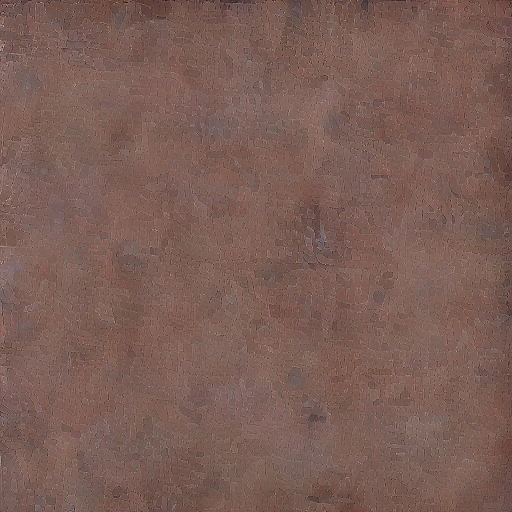

In [ ]:
import model_loader
import pipeline
from PIL import Image
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.is_built or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device {DEVICE}")

vocab_path = "/content/drive/My Drive/Colab Notebooks/Stable Diffusion/data/tokenizer_vocab.json"
merges_path = "/content/drive/My Drive/Colab Notebooks/Stable Diffusion/data/tokenizer_merges.txt"

tokenizer = CLIPTokenizer(vocab_path, merges_file=merges_path)

model_file = "/content/drive/My Drive/Colab Notebooks/Stable Diffusion/data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE ##
prompt = "A dog"
uncond_prompt = ""
do_cfg = True
cfg_scale = 7

## IMAGE TO IMAGE ##
input_image = None
image_path = "/content/drive/My Drive/Colab Notebooks/Stable Diffusion/images/ellie.jpeg"
input_image = Image.open(image_path)
strength = 0.9

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    num_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cuda",
    tokenizer=tokenizer
)

Image.fromarray(output_image)

Originally the image produced was completely black. Debugging efforts have led to the image being completely brown instead. Further debugging is needed to pinpoint the issue. Perhaps the issue lies with the way noise is added or removed from the image. Review of the diffusion.py, ddpm.py (the sampler), and pipeline.py files may prove worthwhile.